# Oligopoly

# Imports

In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# import all of our files
import sys
sys.path.append('../')

import fico
import support_functions as sf

#main model classses
from market import Market
from bank import Bank
from applicant_group import Applicant_group

DATA_DIR = '../data/'

# set plotting parameters
sns.set_context("talk")
sns.set_style("white")

# this needs to be here so we can edit figures later
plt.rcParams['pdf.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/home/michal/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Variables

In [3]:
### Simulation settings ###
time_steps = 100

### Market setting ###
score_range = [300,850]
repay_score = 75
default_score = -150

#this correspends to selection rate(perfect competition [0,1])
plane_range = [0, 1]
plane_slice_step = 0.01

#initial interest rate setting
initial_interest_rate_range = [0.15, 0.1]

#demand and supply interest rate boundaries
max_interest_rate_range = [0.3, 0.2]
min_interest_rate_range = [0.03, 0.02]

#policy
selected_policy = 0  #0=MU, 1=DP , 2=EO 
policy_names = ["Max. utility", "Dem. parity", "Equal opportunity" ]
policy_colors = ['green', 'blue', 'red']

### Bank setting ###
#number of banks in the market
N_banks = 3

#use unique names
bank_names = ["reference", "conservative", "risk taking"]
bank_line_style = ['-.','--', ':']
bank_color = ['red', 'blue', 'green']

#score distribution shift
score_shifts = [0, -25, 50]

#bank interest rate setting
interest_range_reference_bank = [0.15, 0.06]
interest_range_conservative_bank = [0.18, 0.04]
interest_range_risk_bank = [0.1, 0.08]
interest_change_up = 0.01
interest_change_down = -0.01
bank_interest_rate_ranges = [interest_range_conservative_bank, interest_range_risk_bank]

# profit and impact for banks (same for every bank, but different profit and impact can be set for each bank and model different revenue/cost "function")
utility_repaid = 1
utility_default = -4

### Customer groups setting ###
#use unique names
group_names = ["White","Black"]
group_colors = ['grey', 'black']
group_line_style = ['-',':']

#maximal interest rate which are customers willing to accept(linear from score 300-850)
interest_rate_limit = 0.3

#estimated number of customers in each group
white_totals = 8800
black_totals = 1200
loan_demand = 0.1

error_rate = 0#0.5
score_error_black = 0#150
score_error_white = 0#-150

# Prepare initial data

In [5]:
all_cdfs, performance, totals = fico.get_FICO_data(data_dir=DATA_DIR);
cdfs = all_cdfs[group_names]
cdf_groups = np.transpose(cdfs.values)

scores = cdfs.index
scores_list = scores.tolist()
scores_repay = cdfs.index

repays = performance[group_names]

totals = fico.read_totals(data_dir=DATA_DIR)
##### comment to use dataset totals (too many people)
totals['White'] = white_totals
totals['Black'] = black_totals
####
group_totals = np.zeros(len(group_names), dtype=np.int32)
for i in range(0,len(group_names)):
    group_totals[i] = int(totals[group_names[i]])

pis = np.zeros(cdf_groups.shape)
applicant_totals = np.zeros(len(group_names), dtype=np.int32)

for i in range(0, len(group_names)): 
    pis[i] = sf.get_pmf(cdf_groups[i])
    applicant_totals[i] = np.sum(np.round(pis[i]*group_totals[i]))
print("Reference group totals: " + str(group_totals))
print("Calculated group totals: " + str(applicant_totals))

#demographic statistics 
group_ratio = np.array((applicant_totals[0], applicant_totals[1]))
group_size_ratio = group_ratio/group_ratio.sum()
print("Group size ratio: " + str(group_size_ratio))

pis_total = np.round(pis*group_totals[:, None])

ref_applicant_scores = sf.get_ref_applicants(applicant_totals, pis_total, scores_list)

Reference group totals: [8800 1200]
Calculated group totals: [8805 1193]
Group size ratio: [0.88067614 0.11932386]


../fico.py:63: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  cdfs = cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[0]))
../fico.py:64: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  performance = 100 - cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[1]))
../fico.py:28: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  frame = cleanup_frame(pd.DataFrame.from_csv(data_dir + FILES['overview']))


# Create Model

In [6]:
#create market
market = Market(policy_names[selected_policy], policy_colors[selected_policy], score_range = score_range ,repay_score = repay_score, default_score = default_score, max_interest_rate_range = max_interest_rate_range, min_interest_rate_range = min_interest_rate_range, plane_range= plane_range, plane_slice_step = plane_slice_step)

#create banks
reference_bank = Bank(bank_names[0], bank_color[0],bank_line_style[0], interest_range_reference_bank, market, score_shift=score_shifts[0], utility_repaid=utility_repaid, utility_default = utility_default)
conservative_bank = Bank(bank_names[1], bank_color[1], bank_line_style[1], interest_range_conservative_bank, market, score_shift=score_shifts[1], utility_repaid=utility_repaid, utility_default = utility_default)
risk_taking_bank = Bank(bank_names[2], bank_color[2], bank_line_style[2], interest_range_risk_bank, market, score_shift=score_shifts[2], utility_repaid=utility_repaid, utility_default = utility_default)
banks=[reference_bank, conservative_bank, risk_taking_bank]

#create groups
white_group = Applicant_group(group_names[0], group_colors[0], group_line_style[0], applicant_totals[0], ref_applicant_scores[0], loan_demand, error_rate, score_error_white, market, repays, interest_rate_limit=interest_rate_limit)
black_group = Applicant_group(group_names[1], group_colors[1], group_line_style[1], applicant_totals[1], ref_applicant_scores[1], loan_demand, error_rate, score_error_black, market, repays, interest_rate_limit=interest_rate_limit)
groups = [white_group, black_group]

### Init model values

In [7]:

for bank in banks:
    market.max_irates[bank.name] = []
    market.min_irates[bank.name] = []
    market.max_irates[bank.name].append(bank.interest_rate_range[0])
    market.min_irates[bank.name].append(bank.interest_rate_range[1])

    for group in groups:
        bank.N_loan_curves[group.name] = []
        bank.total_utility_curves[group.name] = []

group_mean_score_change_curve = {}
total_loans = {}
total_utility = {}
for group in groups:      
    group_mean_score_change_curve[group.name] = [0]
    market.loans[group.name] = [0]
    market.utility[group.name] = [0]
    total_loans[group.name] = 0
    total_utility[group.name] = 0

# Next step

############### STEP 0 -> 1 ##################
White group mean score change: 3.867802385008531
Black group mean score change: 0.6244761106454462
reference bank - Market share: 0.0, Interest rate: [0.14, 0.05]
conservative bank - Market share: 0.6461428315732952, Interest rate: [0.19, 0.05]
risk taking bank - Market share: 0.4846617173273568, Interest rate: [0.1, 0.08]
Loans - White: 676, Utility - White: 0.6192307692307708
Loans - Black: 32, Utility - Black: -0.03709375000000002
Loans - Total: 708.0, Utility - Total: 0.5895663841807924



../market.py:293: RuntimeWarning: invalid value encountered in true_divide
  ax[2][1].plot(list(range(len(self.utility[group.name]))), np.array(self.utility[group.name])/np.array(self.loans[group.name]), color = group.color, LineStyle = group.line_style,label = "Total utility per loan for "+ group.name + " group")
../market.py:304: RuntimeWarning: invalid value encountered in true_divide
  ax[2][1].plot(list(range(len(total_utility))), np.array(total_utility)/np.array(total_loans), color="red",label= "Total utility per loan")


############### STEP 1 -> 2 ##################
White group mean score change: 7.633390119250407
Black group mean score change: 1.5339480301760204
reference bank - Market share: 0.9643030205136488, Interest rate: [0.15, 0.06]
conservative bank - Market share: 0.0, Interest rate: [0.18, 0.04]
risk taking bank - Market share: 0.17801638881039844, Interest rate: [0.09, 0.07]
Loans - White: 1372, Utility - White: 0.6220838921282812
Loans - Black: 59, Utility - Black: 0.12573050847457623
Loans - Total: 1431.0, Utility - Total: 0.6016192872117413

############### STEP 2 -> 3 ##################
White group mean score change: 11.360817717206146
Black group mean score change: 2.5515507124895294
reference bank - Market share: 0.0, Interest rate: [0.14, 0.05]
conservative bank - Market share: 0.45383682660661706, Interest rate: [0.19, 0.05]
risk taking bank - Market share: 0.5775812892184826, Interest rate: [0.1, 0.08]
Loans - White: 2011, Utility - White: 0.6556118846345073
Loans - Black: 87, Uti

KeyboardInterrupt: 

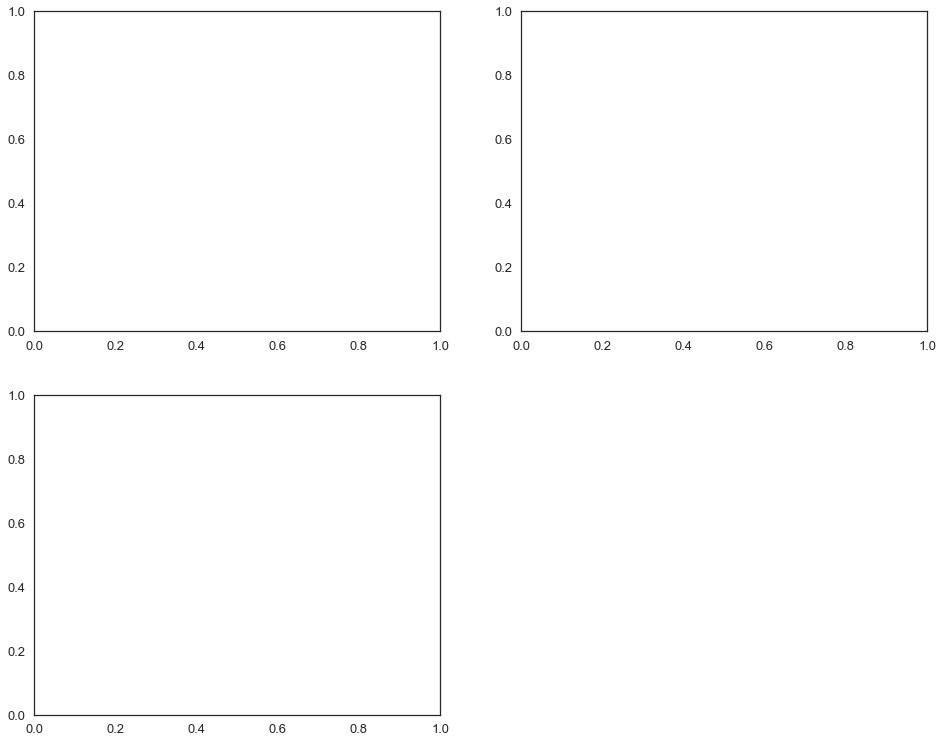

In [11]:
for time in range(0, time_steps):
    print("############### STEP "+ str(market.step) + " -> " + str(market.step+1) + " ##################" )
    utilities = {}
    utility_curves = {}
    N_loans = {}
    step_loans = 0
    step_applicants = 0
    
    ### Before ###            
    selection_rates, max_util = market.get_selection_rate(banks, groups)
    for bank in banks:
        bank.set_selection_rate(selection_rates[bank.name])
        utilities[bank.name] = {}
        utility_curves[bank.name] = {}
        N_loans[bank.name] = {}

    ### During ###
    for group in groups:
        for bank in banks:
            utilities[bank.name][group.name] = 0
            utility_curves[bank.name][group.name] = []
            N_loans[bank.name][group.name] = 0
            
        #select part of customer base at random according to group loan demand
        applicants = np.sort(random.sample(range(0, group.size), int(group.size*group.loan_demand)))
        step_applicants += len(applicants) 
        #go over all selected customers in the group
        for j in applicants:
            best_bank = None
            best_interest_rate = np.Infinity
            
            # check which bank gives best interest rate
            for k in range(len(banks)):
                if j/group.size <= banks[k].group_selection_rate[group.name]:
                    expected_applicant_score = banks[k].get_expected_applicant_score(market, group.scores[j])
                    interest_rate = banks[k].score_interest_rates[expected_applicant_score]
                    if interest_rate < best_interest_rate and interest_rate < group.interest_rate_limit:
                        best_interest_rate = interest_rate
                        best_bank = k

            #print(best_bank)
            if best_bank is not None:                
                #get loan outcome and change score
                step_loans += 1
                total_loans[group.name] += 1
                N_loans[banks[best_bank].name][group.name] += 1 
                real_applicant_score = group.real_scores[j]
                loan_outcome = group.get_repay_outcome(group.score_repay_prob[real_applicant_score])
                expected_applicant_score = banks[best_bank].get_expected_applicant_score(market, group.scores[j])
                group.change_score(market, j, loan_outcome)
                group.change_real_score(market, j, loan_outcome)
                
                #get bank utility
                interest_rate = banks[best_bank].score_interest_rates[group.scores[j]]
                utility_change = banks[best_bank].get_applicant_utility(interest_rate, loan_outcome)
                utilities[banks[best_bank].name][group.name] += utility_change
                total_utility[group.name] += utility_change
                utility_curves[banks[best_bank].name][group.name].append(utilities[banks[best_bank].name][group.name])           
 
        for bank in banks:
            if market.step == 0:
                bank.N_loan_curves[group.name].append(N_loans[bank.name][group.name])
                bank.total_utility_curves[group.name].append(utilities[bank.name][group.name])
            else:
                bank.N_loan_curves[group.name].append(bank.N_loan_curves[group.name][-1] + N_loans[bank.name][group.name])
                bank.total_utility_curves[group.name].append(bank.total_utility_curves[group.name][-1] + utilities[bank.name][group.name])        
        group.sort_scores()
        group_mean_score_change_curve[group.name].append(group.get_mean_score_change())
        print(group.name + " group mean score change: " + str(group.get_mean_score_change()))
    
    market.step += 1 
    
    ### After ###
    #adjust interest rate, we will need market share and utilities for this
    for bank in banks:

        bank_clients = 0
        total_clients = 0
        max_expected_utility = 0
        real_utility = 0
        #calculate market share and utilities
        for group in groups:
            bank.real_group_utility_curve[group.name] = utility_curves[bank.name][group.name]
            total_clients += group.size * group.loan_demand * bank.group_selection_rate[group.name]
            bank_clients += len(bank.real_group_utility_curve[group.name])   
            max_expected_utility += np.max(bank.expected_group_utility_curve[group.name])* group.loan_demand

            if len(bank.real_group_utility_curve[group.name])>0:
                real_utility += bank.real_group_utility_curve[group.name][-1]                                   

        bank.market_share = bank_clients/total_clients 
        #change interest rate according to actual market share and utility
        if bank.market_share >= 1/len(banks) and real_utility >= max_expected_utility/len(banks):
            bank.change_interest_rate(interest_change_up, market)
        elif bank.market_share < 1/len(banks):
            bank.change_interest_rate(interest_change_down, market)
        
        print(bank.name + " bank - Market share: "  + str(bank.market_share) + ", Interest rate: " + str(bank.interest_rate_range))   
        
        market.max_irates[bank.name].append(bank.interest_rate_range[0])
        market.min_irates[bank.name].append(bank.interest_rate_range[1])
    
    for group in groups:
        market.loans[group.name].append(total_loans[group.name])
        market.utility[group.name].append(total_utility[group.name])

    market.plot_market_situation_oligo(banks, groups, group_mean_score_change_curve)

# Playing with TC, TR, MC, MR and UC

6110
1556.2701820801522 1547.812794240599
1537.7471999999216 1569.5424000000685


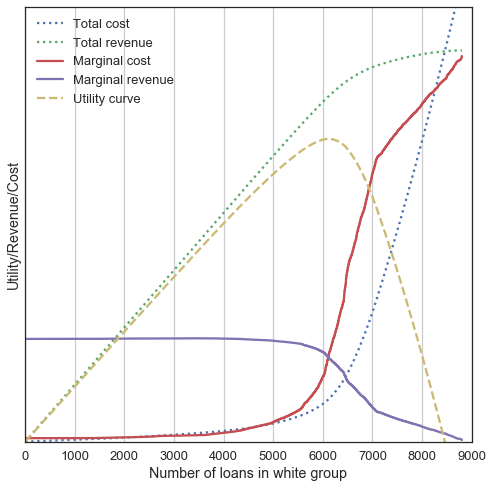

In [14]:
TC_curve = [0]
TR_curve = [0]
MC_curve = []
MR_curve = []
utility_curve = []
TC=0
TR=0
utility=0

n=0

for k in range(0, groups[n].size):
    expected_applicant_score = banks[0].get_expected_applicant_score(market,groups[n].scores[k])
    utility += banks[0].get_applicant_evaluation_utility(expected_applicant_score, groups[n])
    utility_curve.append(utility*1)
    TC += -banks[0].utility_default*(1-groups[n].score_repay_prob[expected_applicant_score])
    TR += (banks[0].utility_repaid+banks[0].score_interest_rates[expected_applicant_score])*groups[n].score_repay_prob[expected_applicant_score]
    TC_curve.append(TC)
    TR_curve.append(TR)
    MC_curve.append((TC_curve[-1] - TC_curve[-2])*1800)
    MR_curve.append((TR_curve[-1] - TR_curve[-2])*1800)
    
plt.figure(figsize=(8,8))
plt.plot(list(range(0, len(TC_curve))),TC_curve,LineStyle=":",label="Total cost")
plt.plot(list(range(0, len(TR_curve))),TR_curve,LineStyle=":",label="Total revenue")
plt.plot(list(range(0, len(MC_curve))),MC_curve,label="Marginal cost")
plt.plot(list(range(0, len(MR_curve))),MR_curve,label="Marginal revenue")
plt.plot(list(range(0, len(utility_curve))),utility_curve,LineStyle="--",label="Utility curve")
plt.xlabel("Number of loans in white group")
plt.ylabel("Utility/Revenue/Cost")
plt.ylim(0,8000)
plt.xlim(0,9000)
plt.yticks([])
plt.grid("on")
plt.legend()
plt.show

print(utility_curve.index(max(utility_curve)))
i =utility_curve.index(max(utility_curve))
print(MR_curve[i],MR_curve[i+1])
print(MC_curve[i],MC_curve[i+1])

# Perfect competition market

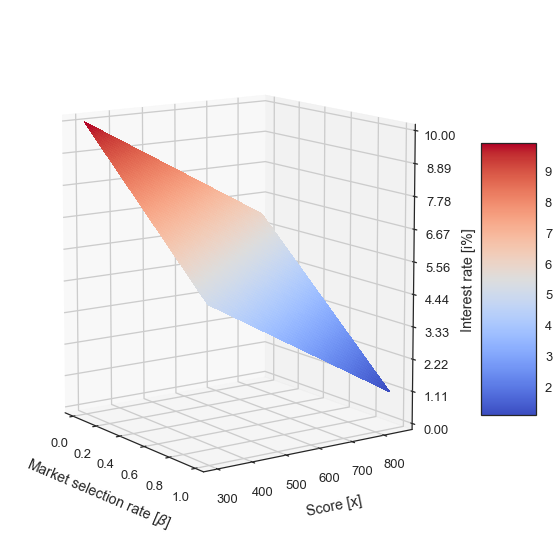

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(0, 1, 0.01)
Y = np.arange(300, 850, 1)
X, Y = np.meshgrid(X, Y)
Z = 5-X*5 + 5-((Y-300)/550)*4 

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 10)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel(r'Market selection rate [$\beta$]')
ax.set_ylabel('Score [x]')
ax.set_zlabel('Interest rate [i%]')
ax.view_init(elev=10., azim=-35)
ax.xaxis.labelpad = 18
ax.yaxis.labelpad = 18
ax.zaxis.labelpad = 18


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Imperfect competition cartel market

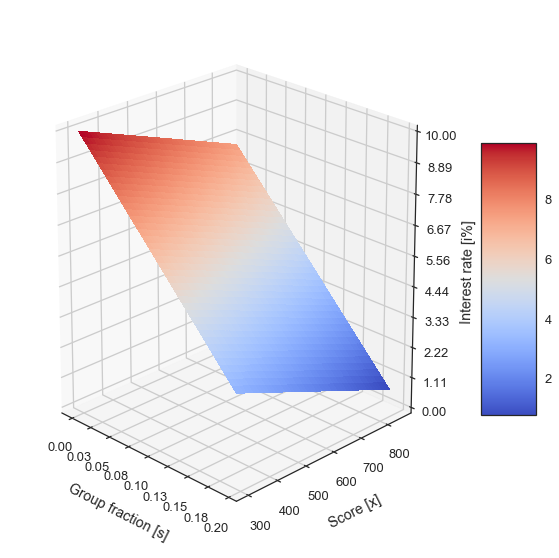

In [16]:
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(0, 0.2, 0.005)
Y = np.arange(300, 850, 1)
X, Y = np.meshgrid(X, Y)
Z = 7-X*35 + 3 - ((Y-300)/550)*2.5 

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 10)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel(r'Group fraction [s]')
ax.set_ylabel('Score [x]')
ax.set_zlabel('Interest rate [i%]')
ax.view_init(elev=20, azim=-45)
ax.xaxis.labelpad = 18
ax.yaxis.labelpad = 18
ax.zaxis.labelpad = 18


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()